<a href="https://colab.research.google.com/github/jianxu305/DXY-2019-nCoV-Data/blob/master/death_rate_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/jianxu305/nCov2019_analysis/

import sys
import os
os.chdir('/content/nCov2019_analysis/src')

sys.path.append('/content/nCov2019_analysis/src')

Cloning into 'nCov2019_analysis'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 198 (delta 104), reused 116 (delta 47), pack-reused 0
Receiving objects: 100% (198/198), 12.48 MiB | 27.07 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils   # some convenient functions
import matplotlib.font_manager as mfm
import datetime

%load_ext autoreload
%autoreload 2

In [3]:
data = utils.load_chinese_data()

Last update:  2020-02-21 20:57:17.698000
Data date range:  2020-01-24 to 2020-02-21
Number of rows in raw data:  50000


In [0]:
daily_frm = utils.aggDaily(data)

## 1. Sanity Check
### 1.1 Take a Brief Look at the data

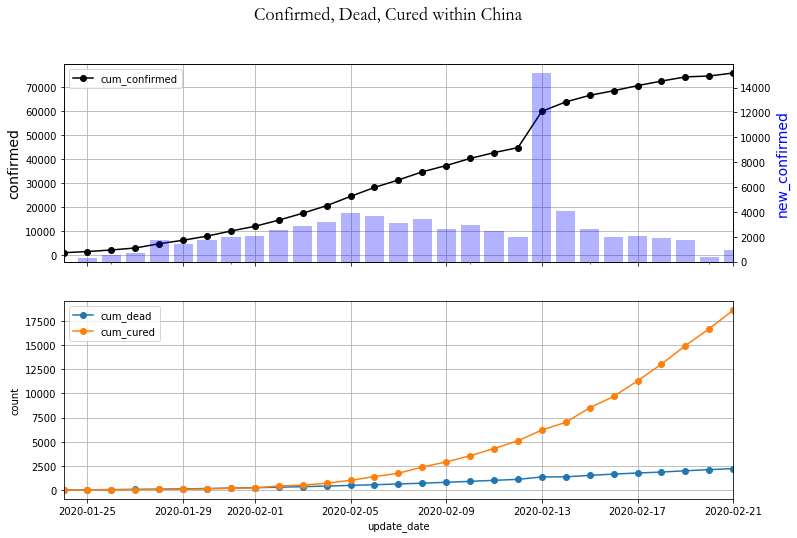

In [7]:
fig = utils.tsplot_conf_dead_cured(daily_frm, title='Confirmed, Dead, Cured within China', figsize=(12, 8))

### 1.2 Confirm the ~2% mortality rate

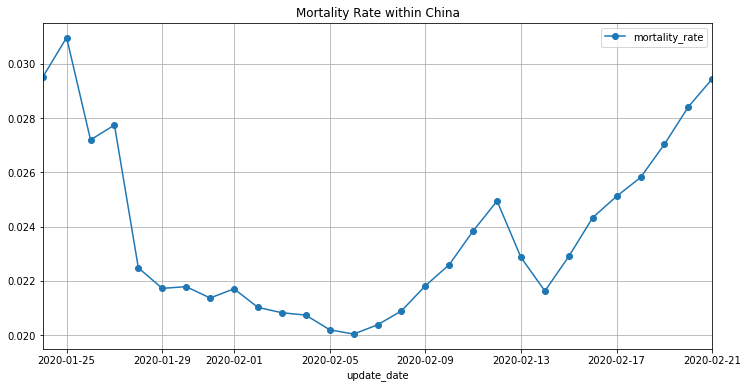

In [8]:
avg_frm = daily_frm.groupby('update_date').agg('sum')
avg_frm['mortality_rate'] = avg_frm['cum_dead'] / avg_frm['cum_confirmed']
avg_frm.plot(y='mortality_rate', grid=True, figsize=(12, 6), marker='o', title='Mortality Rate within China')

## 2. Mortality Rate Disparity

In [0]:
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
api_key  = '6VpHS4tMBHIyTabsRXNE'
user_name = 'jxu1'
chart_studio.tools.set_credentials_file(username=user_name, api_key=api_key)

### Split the mortality rate into three regions:
Wuhan, Hubei Province except Wuhan, and China except Hubei Province

In [0]:
daily_frm['region'] = np.where(daily_frm['city_name_en'] == 'Wuhan', 'Wuhan', 
                  np.where(daily_frm['province_name_en'] == 'Hubei', 'Hubei_ex_Wuhan', 'China_ex_Hubei'))
region_frm = daily_frm.drop(columns='zip_code').groupby(['region', 'update_date']).agg('sum')
region_frm['mortality_rate'] = region_frm['cum_dead'] / region_frm['cum_confirmed']

In [11]:
fig = px.bar(region_frm.reset_index(), x='update_date', y='new_confirmed', color='region', 
        title='Daily New Confirmed Count in Different Regions')
fig.show()

In [12]:
fig = px.line(region_frm.reset_index(), x='update_date', y='mortality_rate', color='region', 
        title='Mortality Rate in Different Regions')
fig.add_trace(go.Scatter(x=avg_frm.index.get_level_values('update_date'), 
                         y = avg_frm['mortality_rate'],
                         line={'dash': 'dash'},
                         name='National Average'))
fig.show()

In [20]:
py.plot(fig, filename='mortality_rate_vs_date_by_region', auto_copen=True) # upload

'https://plot.ly/~jxu1/98/'

## 3. Better Estimates of Mortality Rate

In [0]:
lag_frm = region_frm.copy()
lags = [4, 8]
for lag in lags:
    lag_frm['cum_confirmed_lag' + str(lag)] = lag_frm.groupby(['region'])['cum_confirmed'].shift(lag)
    lag_frm['mortality_rate_lag' + str(lag)] = lag_frm['cum_dead'] / lag_frm['cum_confirmed_lag' + str(lag)]

In [0]:
# remove earlier dates to improve visually due to the lags
lag_frm = lag_frm.reset_index()
lag_frm = lag_frm[lag_frm['update_date'] >= pd.to_datetime('2020-02-05')].set_index(['region', 'update_date'])

In [43]:
fig = px.line(lag_frm.reset_index(), x='update_date', y='mortality_rate', color='region', 
        title='Mortality Rate in Different Regions and Different Lags')
for lag, line_style in zip(lags, ['dash', 'dot']):
    for region, color in zip(['Wuhan', 'Hubei_ex_Wuhan', 'China_ex_Hubei'], ['cyan', 'red', 'blue']):
        fig.add_trace(go.Scatter(x=lag_frm.index.get_level_values('update_date'), 
                                y = lag_frm.loc[region]['mortality_rate_lag' + str(lag)],
                                line={'dash': line_style, 'color':color},
                                mode='lines',
                                name='region=' + region + ', lag' + str(lag)))
fig.show()

In [44]:
py.plot(fig, filename='mortality_rate_vs_date_by_region_lag', auto_copen=True) # upload

'https://plot.ly/~jxu1/106/'

### 2.1 Compare mortality rate by province

In [0]:
province = daily_frm.groupby(['update_date', 'province_name_en']).agg('sum')
province['mortality_rate'] = province['cum_dead'] / province['cum_confirmed']

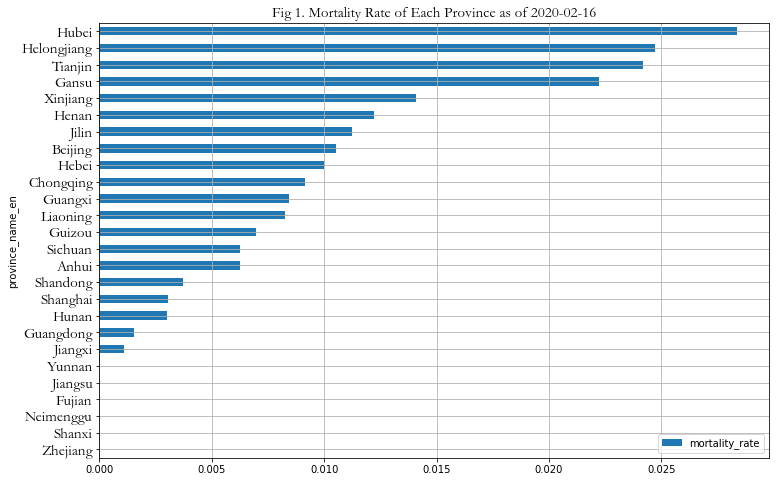

In [10]:
fig = utils.cross_sectional_bar(province.loc[(datetime.date(2020, 2, 16), ), :], 
                                None, col='mortality_rate', groupby='province_name_en', 
                                title='Fig 1. Mortality Rate of Each Province as of 2020-02-16',
                                figsize=(12, 8))
plt.show()

The above plot only shows the rate, but not the "severity".  So try adding the cumulative confirmed cases, and the 7-day trending info

In [11]:
ma = province.reset_index('province_name_en').groupby('province_name_en')['new_confirmed', 'new_dead'].rolling(5, min_periods=1).mean()
# ma from above is indexed by (province, date), which is different order than province's (date, index)
# so direct assignment will result in NA, need to swaplevel first
ma = ma.swaplevel()
province['new_confirmed_MA'] = ma['new_confirmed']
province['new_dead_MA'] = ma['new_dead']

# The next two columns are mainly for plot rendering
province['new_confirmed_logMA'] = np.log10(province['new_confirmed_MA'] + 2)  
province['new_dead_logMA'] = np.log10(province['new_dead_MA'] + 2)

province.loc[(slice(None), 'Hubei'), :].tail()

,,zip_code,cum_confirmed,cum_cured,cum_dead,new_confirmed,new_cured,new_dead,mortality_rate,new_confirmed_MA,new_dead_MA,new_confirmed_logMA,new_dead_logMA
update_date,province_name_en,,,,,,,,,,,,
2020-02-16,Hubei,7187536.0,56249,5666,1596,1843.0,845.0,139.0,0.028374,4904.2,124.4,3.690745,2.101747
2020-02-17,Hubei,7187536.0,58182,6693,1696,1933.0,1027.0,100.0,0.029150,4963.2,125.6,3.695937,2.105851
2020-02-18,Hubei,7187536.0,59989,7943,1789,1807.0,1250.0,93.0,0.029822,2356.6,95.8,3.372654,1.990339
2020-02-19,Hubei,7187536.0,61682,9336,1921,1693.0,1375.0,132.0,0.031144,1939.2,120.6,3.288070,2.088490
2020-02-20,Hubei,7187536.0,62031,10518,2029,349.0,1194.0,108.0,0.032709,1525.0,114.4,3.183839,2.065953


In [108]:
fig = px.scatter(province.loc[(datetime.date(2020, 2, 16), ), :].reset_index(), 
                 x='cum_confirmed', 
                 y='mortality_rate', 
                 size='new_confirmed_logMA', 
                 color='new_dead_logMA',
                 color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['province_name_en', 'cum_dead', 'cum_confirmed', 'new_confirmed_MA', 'new_dead_MA'],
                 title='Mortality Rate vs Confirmed by Province, sized by log(recent 5-day average death count)')
fig.update_layout(xaxis_type="log")
fig.show()

In [1]:
tmp = province.loc[(datetime.date(2020, 2, 16), ), :].reset_index()
tmp = tmp[tmp['province_name_en'] != 'Hubei']
fig2 = px.scatter(tmp, 
                 x='cum_confirmed', 
                 y='mortality_rate', 
                 size='new_confirmed_MA', 
                 #color='new_dead',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['province_name_en', 'cum_dead', 'cum_confirmed', 'new_confirmed_MA', 'new_dead_MA'],
                 title='Mortality Rate vs Confirmed by Province Except Hubei, sized by log(recent 5-day average death count)')
fig2.update_layout(xaxis_type="log")
fig2.show()

NameError: ignored

In [39]:
py.plot(fig, filename='mortality_rate_by_region', auto_copen=True)

'https://plot.ly/~jxu1/100/'

In [41]:
py.plot(fig2, filename='new_confirm_by_region', auto_copen=True)

'https://plot.ly/~jxu1/102/'

# Death rate by city within Hubei

In [0]:
tmp = daily_frm[daily_frm['province_name_en'] == 'Hubei'].copy().set_index(['update_date', 'city_name_en'])
tmp['new_confirmed_MA'] = tmp.reset_index('city_name_en').groupby('city_name_en')['new_confirmed'].rolling(5, min_periods=1).mean().swaplevel()
tmp['mortality_rate'] = tmp['cum_dead'] / tmp['cum_confirmed']
tmp = tmp.reset_index()
tmp_ex_Wuhan = tmp[tmp['city_name_en'] != 'Wuhan']


In [106]:
fig2 = px.scatter(tmp_ex_Wuhan[tmp_ex_Wuhan['update_date'] == pd.to_datetime('2020-02-16')], 
                 x='cum_confirmed', 
                 y='mortality_rate', 
                 size='new_confirmed_MA', 
                 #color='new_dead_MA',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['city_name', 'province_name_en', 'cum_dead', 'cum_confirmed'],
                 title='Mortality Rate vs Confirmed by cities in Hubei (Except Wuhan), sized by recent confirm counts')
fig2.update_layout(xaxis_type="log")
fig2.show()